# MUDE W3- Gradient Estimation 



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>

<b>Info:</b> 

This notebook is a very simple draft showing how we could use data from the Nenana Ice Classic in the numerical modelling part.

The implementation is not particularly efficient, but it is quite flexible.

The dataset used is loaded from github, but a few extra packages are needed(`io` and  `requests`).

 We could avoid this issue by instructing to download the file and loaded from the directory that they save it.

</p>
</div>


In [1]:
from io import StringIO
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly 

def import_data_browser(url):
    """
    This function imports data from a specified URL.

    Parameters:
    url (str): The URL from which to import the data.

    Returns:
    None

    Comments:
    This function is needed to load data in a browser, as the environment used does not support absolute/relative path imports 
    """
   
    response = requests.get(url)
    csv_data = StringIO(response.text)

    return csv_data
def plot_columns_interactive(df, column_groups: dict, title: str | None = None, 
                             xlabel: str | None = 'Date', 
                             y_domains: dict | None = None)-> go.Figure: 
    """
    Plot columns of a DataFrame in interactive plots with multiple y-axes using Plotly.

    Parameters
    -----------
    df : pandas.DataFrame
        The input DataFrame.
    column_groups : dict
        A dictionary where keys are group names and values are lists of column names to be plotted together.
    title : str, optional
        The title of the plot.
    xlabel : str, optional
        The label for the x-axis.
    date_focus : str, optional
        The initial focus point of the date selector buttons. Format: 'YYYY-MM-DD'.

    Returns
    -------
    fig : plotly.graph_objs.Figure
    """
    fig = go.Figure()
    
    num_groups = len(column_groups)
    y_domains = {i: [i / num_groups, (i + 1) / num_groups] for i in range(num_groups)}

    # Add traces for each column group with separate y-axes
    for i, (group_name, columns) in enumerate(column_groups.items(), start=1):
        y_axis = f'y{i}'
        for column in columns:
            if column in df.columns:
                col_data = df[column].copy()
                col_data.dropna(inplace=True)
                fig.add_trace(go.Scatter(x=col_data.index, y=col_data, mode='lines', name=f"{group_name}: {column}", yaxis=y_axis))
            else:
                print(f"Warning: Column '{column}' not found in DataFrame")
        
        # Update layout to add a new y-axis
        fig.update_layout(
            **{f'yaxis{i}': dict(
                title=f"{group_name}", 
                anchor='x', 
                overlaying='y', 
                side='left', 
                domain=y_domains.get(i-1, [0, 1]), 
                showline=True,
                linecolor="black",
                mirror=True,
                tickmode="auto",
                ticks="",
                titlefont={"color": "black"},
                type="linear",
                zeroline=False
            )}
        )
    
    # General layout updates
    fig.update_layout(
        title=title,
        xaxis=dict(
            title=xlabel, 
            rangeslider=dict(visible=True), 
            type="date",
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all")
                ])
            )
        ),
        dragmode="zoom",
        hovermode="x",
        legend=dict(traceorder="reversed",
        x=0,
        y=1,
        xanchor='left',
        yanchor='top',
        orientation='v'
    ),
        height=800,
        template="plotly",
        margin=dict(t=90, b=150)
    )

    # Add break up times shapes if necessary
    file3=import_data_browser('https://raw.githubusercontent.com/iceclassic/mude/main/book/data_files/BreakUpTimes.csv')
    break_up_times = pd.read_csv(file3)
    break_up_times['timestamp'] = pd.to_datetime(break_up_times[['Year', 'Month', 'Day', 'Hour', 'Minute']])
    break_up_times.set_index('timestamp', inplace=True)
    shapes = []
    for date in break_up_times.index:
        shape = {"type": "line", "xref": "x", "yref": "paper", "x0": date, "y0": 0, "x1": date, "y1": 1,
                 "line": {"color": 'red', "width": 0.6, "dash": 'dot'}, 'name': 'break up times'}
        shapes.append(shape)

    fig.update_layout(shapes=shapes)
    # dumm line to add to legend
    fig.add_trace(go.Scatter(
        x=[None], y=[None],  
        mode='lines',
        line=dict(color='red', width=0.6, dash='dot'),
        name='Break Up Times',  
        hoverinfo='none',  
        showlegend=True     
    ))
    #fig.show()
    return fig


In [2]:

# we could load the data from the repo
#Data=pd.read_csv("../data_files/Time_series_DATA.txt",skiprows=149,index_col=0,sep='\t')

# or we could load the data from the web ( by fetching the file from github )
file=import_data_browser('https://raw.githubusercontent.com/iceclassic/mude/main/book/data_files/Time_series_DATA.txt')
Data=pd.read_csv(file,skiprows=149,index_col=0,sep='\t')
Data.index = pd.to_datetime(Data.index, format="%Y-%m-%d")

Lets plot the raw timeseries without any modifications,interpolation or other stuff.

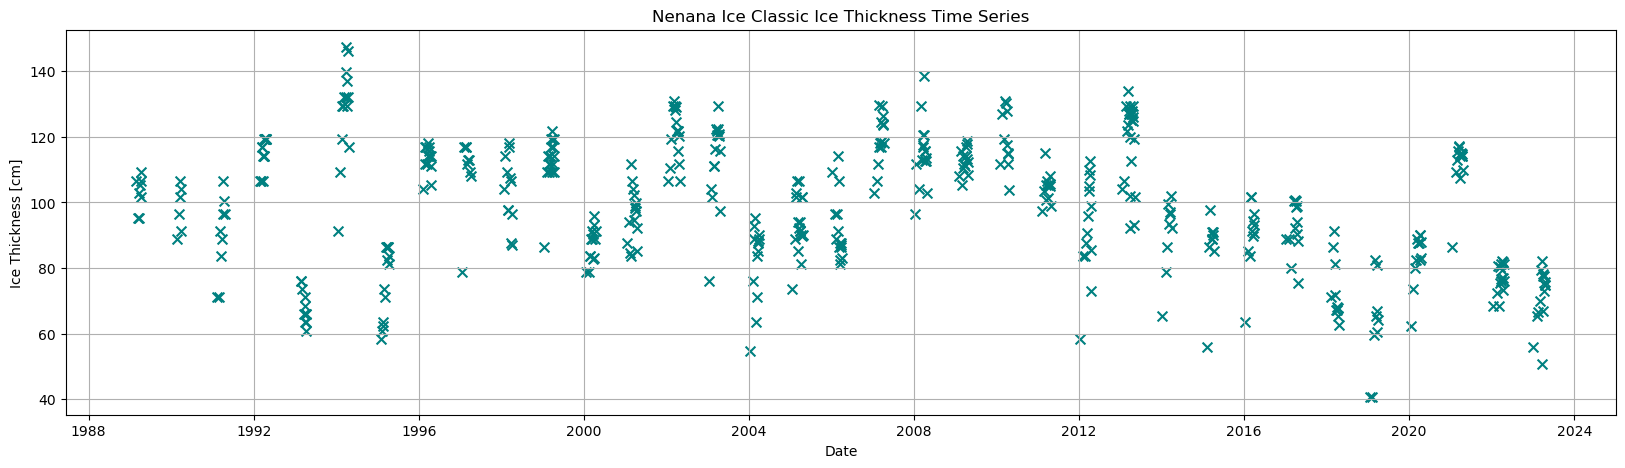

In [3]:
Ice_thickness=Data['IceThickness [cm]']
Ice_thickness=Ice_thickness.dropna(inplace=False) # drop the missing values

plt.figure(figsize=(20,5))
#plt.plot(Ice_thickness)
plt.scatter(Ice_thickness.index,Ice_thickness,color='teal',marker='x',s=50)
plt.title('Nenana Ice Classic Ice Thickness Time Series')
plt.ylabel('Ice Thickness [cm]')
plt.xlabel('Date')
plt.grid()
plt.show()

Instead of vectoring the code and applying the function to the whole time-series, we will group the data by year and apply it to each year. 

~~ Lets use the interactive function so we can zoom-in/scroll to get a better feeling for the data.~~ Interactive plotly plots are finicky, better to not use it unless the env-req is set up properly

In [4]:



# plotly.offline.init_notebook_mode()
# column_groups = {
#     'Iceclassic ': ['IceThickness [cm]'],
#     'Berkeley Earth Global':['Regional: Air temperature [C]']}

# # Plot the specified columns with default y_domains and focus on a specific date
# plot_columns_interactive(Data, column_groups, title="Break up times & Global Variables at Tenana River-Nenana, AK with break-up dates")

## Estimating gradients


In [5]:
def finite_differences(series):
    """Compute forward, central, and backward differences using the step size as days between measurement
    """
   
    days_forward = (series.index.to_series().shift(-1) - series.index.to_series()).dt.days
    days_backward = (series.index.to_series() - series.index.to_series().shift(1)).dt.days
    
    # Forward difference: (f(x+h) - f(x)) / h 
    forward = (series.shift(-1) - series) / days_forward

    # Backward difference: (f(x) - f(x-h)) / h,
    backward = (series - series.shift(1)) / days_backward

    # Central difference: (f(x+h) - f(x-h)) / (h_forward + h_backward)
    central = (series.shift(-1) - series.shift(1)) / (days_forward + days_backward) #
    
    # fixing start/end points
    forward.iloc[-1] = np.nan  
    backward.iloc[0] = np.nan  

    return pd.DataFrame({'forward': forward, 'backward': backward, 'central': central})

In [6]:
result = Ice_thickness.groupby(Ice_thickness.index.year).apply(lambda x: finite_differences(x))
result = result.reset_index(level=0, drop=True)

if we were to implement other methods, we simply create the function and  pass  it in the `apply`. 

For example, using the interpolation from [this notebook](https://github.com/iceclassic/mude/blob/main/book/Part_1/Resampling_%26_Interpolation.ipynb) we could either compute the analytical gradient of the fitted spline, or re-apply the same method above on the interpolated time-series.


### Ploting the gradients,
We can easily change the `xlim` to focus on specific years 

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_gradients(ax, x, y, slopes, length=2, color='blue', label=None, label_flag=True, offset=0):
    """Plot lines with slopes at given points on a plot and annotate them."""
    # Collect annotations
    annotations = []
    for i in range(len(x)):
        if np.isnan(slopes.iloc[i]):
            continue  
        dx = length  
        dy = slopes.iloc[i] * dx  
        # Plot the slope line
        ax.plot(
            [x[i], x[i] + pd.Timedelta(days=dx)], 
            [y.iloc[i], y.iloc[i] + dy], 
            color=color, alpha=0.7, label=label if label_flag else ""
        )
        # Collect annotation data
        annotations.append({
            'x': x[i] + pd.Timedelta(days=dx / 2),
            'y': y.iloc[i] + offset,
            'text': f'{slopes.iloc[i]:.2f}',
            'color': color
        })
        label_flag = False  # Avoid repeating the label for each line

    # Add annotations below scatter points
    for annotation in annotations:
        ax.annotate(
            annotation['text'], 
            (annotation['x'], annotation['y']), 
            color=annotation['color'], fontsize=10, ha='center'
        )

def plot_gradients_and_thickness(result, ice_thickness, year, plot_gradient_as_slope=False):
    """
    Plots ice thickness gradients and ice thickness for a selected year.

    Parameters:
    - result (pd.DataFrame): DataFrame containing the gradients with columns ['forward', 'backward', 'central'].
    - ice_thickness (pd.Series): Series containing ice thickness values indexed by datetime.
    - year (int): The year to filter and plot data for.
    - plot_gradient_as_slope (bool): If True, plots lines with gradients and annotations.
    """
    # Filter data for the selected year
    result_year = result[result.index.year == year]
    ice_thickness_year = ice_thickness[ice_thickness.index.year == year]
    
    if not plot_gradient_as_slope:
        fig, ax1 = plt.subplots(figsize=(20, 5))

        ax1.plot(result_year['forward'], label='Forward', color='red')
        ax1.plot(result_year['backward'], label='Backward', color='green')
        ax1.plot(result_year['central'], label='Central', color='blue')

        ax1.set_ylabel('Gradient [cm/day]')
        ax1.set_xlabel('Date')
        ax1.set_title(f'Ice Thickness Gradients for {year}')
        ax1.grid()
        ax1.set_ylim([-5, 4])

        # Set x-axis limits to the filtered year range
        ax1.set_xlim(result_year.index.min(), result_year.index.max())
        ax1.legend(loc='upper left')

        # Add scatter plot for ice thickness on a secondary y-axis
        ax2 = ax1.twinx()
        ax2.scatter(ice_thickness_year.index, ice_thickness_year, color='black', alpha=0.4, label='Ice Thickness')
        ax2.plot(ice_thickness_year.index, ice_thickness_year, color='black', alpha=0.4)
        ax2.set_ylabel('Ice Thickness [cm]')

        # Combine legends from both y-axes
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper right')

        plt.show()
    else:
        fig, ax = plt.subplots(figsize=(20, 5))

        ax.plot(ice_thickness_year.index, ice_thickness_year, label='Thickness', color='black', linestyle='--', alpha=0.4)
        ax.scatter(ice_thickness_year.index, ice_thickness_year, color='black', alpha=0.4)

        # anottaion code shamelessly copied from the chatgpt
        # Define vertical offsets for each gradient type
        offsets = {'forward': -3, 'backward': -6, 'central': -9}

        # Plot gradients and annotations for each slope type
        for grad_type, color in zip(['forward', 'backward', 'central'], ['red', 'green', 'blue']):
            # Extract corresponding slopes
            slopes = result_year[grad_type]
            # Plot gradients with annotations and specific offset
            plot_gradients(ax, result_year.index, ice_thickness_year, slopes, color=color, label=grad_type.capitalize(), label_flag=True, offset=offsets[grad_type])

        ax.legend()
        ax.set_title('Ice Thickness with Gradient')
        ax.set_xlabel('Date')
        ax.set_ylabel('Ice thickness [cm]')
        ax.grid(True)
        plt.show()




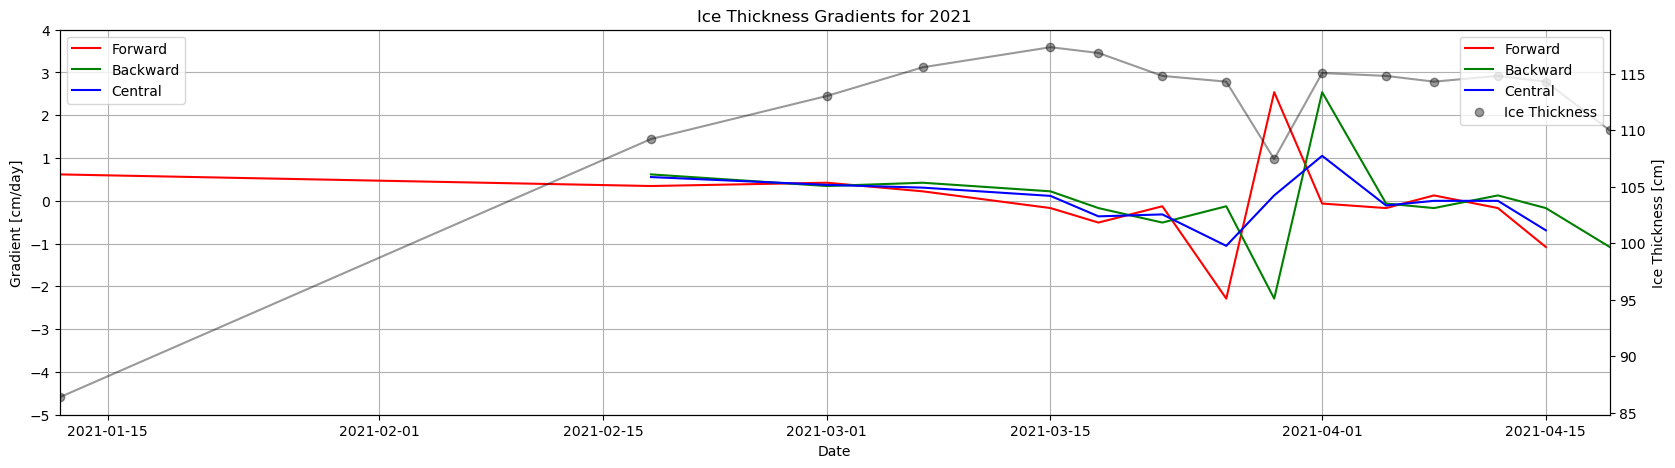

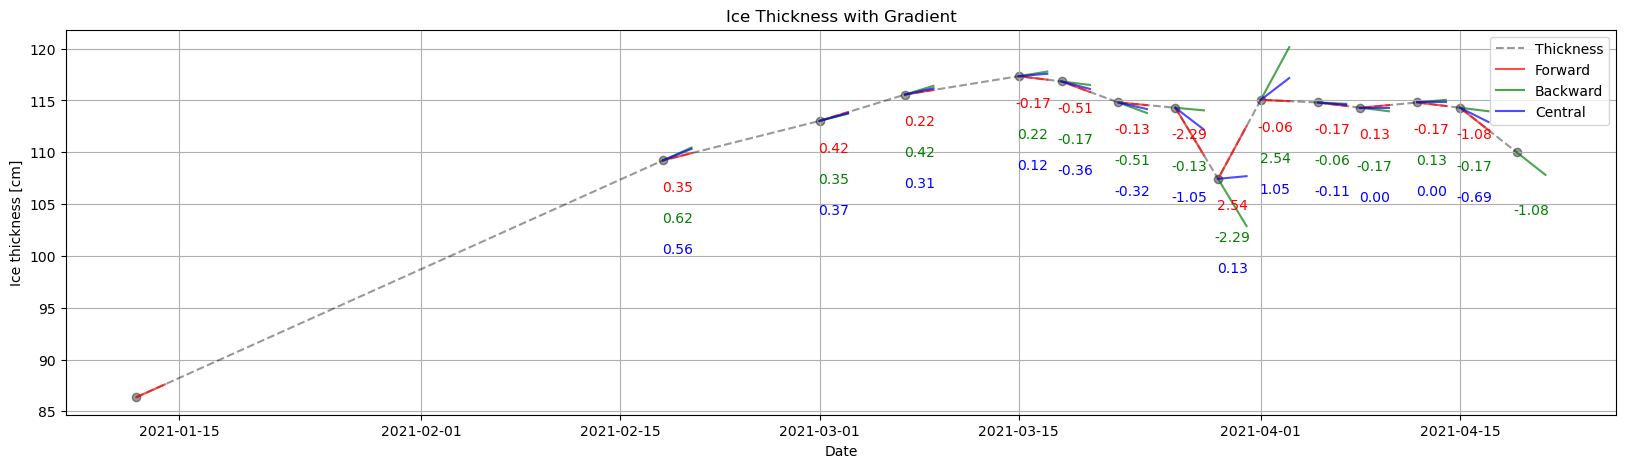

             forward  backward   central
2021-01-12  0.617838       NaN       NaN
2021-02-18  0.346364  0.617838  0.555625
2021-03-01  0.423333  0.346364  0.373529
2021-03-07  0.222250  0.423333  0.308429
2021-03-15 -0.169333  0.222250  0.115455
2021-03-18 -0.508000 -0.169333 -0.362857
2021-03-22 -0.127000 -0.508000 -0.317500
2021-03-26 -2.286000 -0.127000 -1.052286
2021-03-29  2.540000 -2.286000  0.127000
2021-04-01 -0.063500  2.540000  1.052286
2021-04-05 -0.169333 -0.063500 -0.108857
2021-04-08  0.127000 -0.169333  0.000000
2021-04-12 -0.169333  0.127000  0.000000
2021-04-15 -1.079500 -0.169333 -0.689429
2021-04-19       NaN -1.079500       NaN


In [8]:
plot_gradients_and_thickness(result, Ice_thickness, 2021)

plot_gradients_and_thickness(result, Ice_thickness, 2021,plot_gradient_as_slope=True)

print(result[result.index.year==2021])